In [44]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval import Lebesgue
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.operators import SOLAOperator
from pygeoinf.interval.functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import InverseLaplacian, Laplacian
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.linear_bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver
import time

# Set-up folder for saving figures
import os
figures_folder = 'pli_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [45]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
N = 2
M = Lebesgue(N, function_domain, basis='fourier') # model space
N_d = 100 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 10 # number of property points
P = EuclideanSpace(N_p) # property space

In [46]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(
        M,
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=2,
    )
G = SOLAOperator(M, D, normal_modes_provider)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider)

In [47]:
# Create the synthetic true model
m_bar = Function(M, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x)

# Generate synthetic observations
print("Generating synthetic data...")
d_bar = G(m_bar)  # Clean observations
noise_level = 0.1 * np.max(d_bar)
np.random.seed(42)  # For reproducibility
d_tilde = d_bar + np.random.normal(0, noise_level, d_bar.shape)  # Noisy observations

print(f"Signal-to-noise ratio: {np.max(d_bar) / noise_level:.1f}")
print(f"Number of observations: {len(d_tilde)}")


Generating synthetic data...
Signal-to-noise ratio: 10.0
Number of observations: 100


In [48]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data NOISE measure (zero mean) for LinearForwardProblem
# This represents the noise model: η ~ N(0, C_D)
gaussian_D_noise = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure (with observed data mean) for visualization
# This represents the likelihood: d̃ | m ~ N(G(m), C_D)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 0.1111
Relative noise level: 10.0%


In [49]:
# Define prior measure parameters
bc_dirichlet = BoundaryConditions(bc_type='dirichlet', left=0, right=0)
alpha = 0.1  # Amplifier -> the bigger -> the smoother
C_0 = InverseLaplacian(M, bc_dirichlet, alpha, method='fem', dofs=100)

# Define the precision operator
A_0 = Laplacian(M, bc_dirichlet, alpha, method='fd', dofs=100)

# Prior mean (simple linear trend)
m_0 = Function(M, evaluate_callable=lambda x: x)

print(f"Prior covariance: (-{alpha}Δ)⁻¹ with Dirichlet boundary conditions")
print(f"Prior mean: m₀(x) = x")

# Set up Karhunen-Loève expansion for efficient sampling
K = 1000  # Number of KL terms (should be ≥ N for full representation)
print(f"Using {K} Karhunen-Loève terms for prior sampling")

# Create Gaussian measure on model space
M_prior = GaussianMeasure.from_spectral(C_0, n_modes=K)

# Display eigenvalue decay
eigenvals = C_0.get_eigenvalues(range(50))
print(f"Eigenvalue range: [{eigenvals[-1]:.2e}, {eigenvals[0]:.2e}]")
print(f"Spectral decay rate: {eigenvals[0]/eigenvals[-1]:.1e}")

INFO:pygeoinf.interval.fem_solvers:GeneralFEMSolver initialized: dofs=100, domain=[0.0,1.0]
INFO:pygeoinf.interval.operators:InverseLaplacian initialized: dofs=100, fem_type=hat, alpha=0.1
INFO:pygeoinf.interval.operators:LaplacianOperator (finite difference, order 2) initialized with 100 grid points


Prior covariance: (-0.1Δ)⁻¹ with Dirichlet boundary conditions
Prior mean: m₀(x) = x
Using 1000 Karhunen-Loève terms for prior sampling
Eigenvalue range: [4.05e-04, 1.01e+00]
Spectral decay rate: 2.5e+03


In [50]:
# Commputing the normal operator
Lambda = G @ C_0 @ G.adjoint + gaussian_D_noise.covariance

# And the inverse
solver = CholeskySolver(parallel=True, n_jobs=8)
Lambda_inv = solver(Lambda)

In [88]:
C_post = C_0 - C_0 @ G.adjoint @ Lambda_inv @ G @ C_0
expectation=m_0 + (C_0 @ G.adjoint @ Lambda_inv)(d_tilde - G(m_0))

In [89]:
C_p = T @ C_post @ T.adjoint

In [82]:
M_finer = Lebesgue(N*50, function_domain, basis='sine') # finer model space for visualization

In [ ]:
C_post._domain = M_finer
C_post._codomain = M_finer

In [ ]:
C_post_matrix = C_post.matrix(dense=True, parallel=True, n_jobs=8)
M_posterior = GaussianMeasure.from_covariance_matrix(M_finer, C_post_matrix, expectation=expectation)

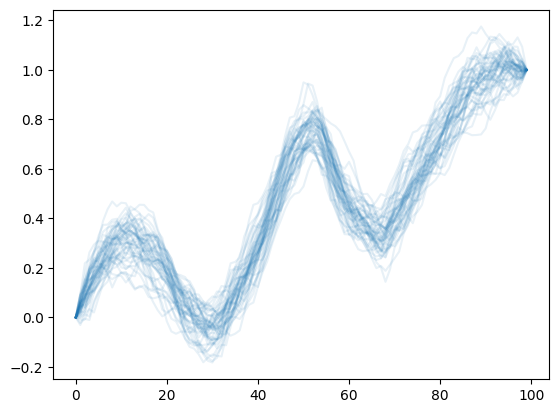

In [85]:
x = function_domain.uniform_mesh(100)
fig = plt.figure()
for i in range(50):
    plt.plot(M_posterior.sample().evaluate(x), color='tab:blue', alpha=0.1)